# Problema 6
## Planteamiento
Determinar los patrones de consumo eléctrico en una casa es importante para poder determinar la cantidad de energía necesaria para suministrar en una ciudad. Es claro que el consumo eléctrico varía dependiendo de las estaciones y de las actividades que se realicen en la casa. Sin embargo, determinar los patrones si es posible determinar periodos demayor consumo y periodos de menor consumo podría ayudar a responder esta pregunta.

La problemática es estudiar la periodicidad de estos consumos al día y determinar si es posible predecir los periodos de mayor consumo y los periodos de menor consumo.

La base de datos asociada a este problema es: https://www.kaggle.com/datasets/vitthalmadane/energy-consumption-time-series-dataset


## Metodología

#### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams.update(plt.rcParamsDefault)
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform,pdist
from nolitsa import dimension, delay
import math
import persim
import datetime

#### Limpieza de Datos

In [2]:
data1 = pd.read_csv('Consumo.csv')
data2= pd.read_csv('consumo2.csv')
data3= pd.read_csv('consumo3.csv')

In [3]:
frames=[data1,data2,data3]
todo=pd.concat(frames)
todo = todo.drop(todo.columns[0], axis=1)
todo=todo.dropna()
todo =todo.rename(columns={"TxnDate": "Fecha", "TxnTime": "Tiempo"})

Solo tomaremos en cuenta las horas del dia, por lo que reordenaremos los datos por hora

In [4]:
todo=todo.sort_values(by='Tiempo')


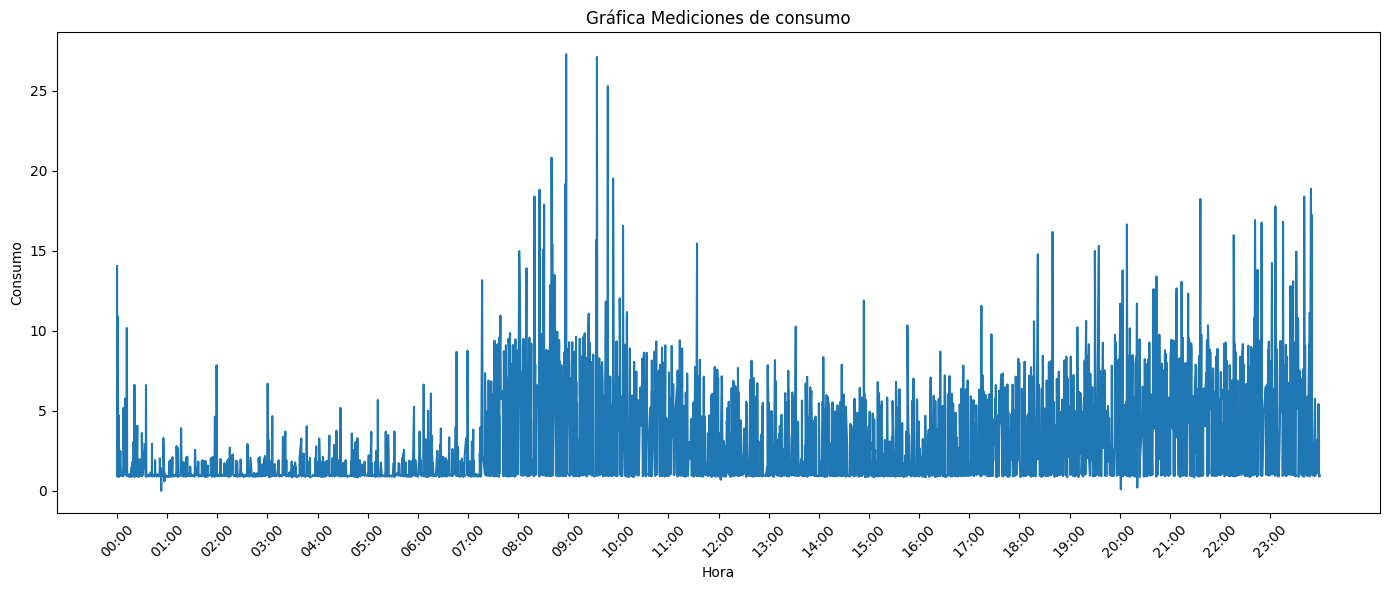

In [5]:
todo['TiempoconOtroFormato'] = pd.to_datetime(todo['Tiempo'], format='%H:%M:%S')

plt.figure(figsize=(14, 6))
plt.plot(todo['TiempoconOtroFormato'], todo['Consumption'], linestyle="solid")  # Puedes cambiar el estilo de línea si lo deseas

# Configurar etiquetas y títulos (opcional)
plt.xlabel("Hora")
plt.ylabel("Consumo")
plt.title("Gráfica Mediciones de consumo")

# Configura las etiquetas del eje x con formato de hora
labels = pd.date_range(todo['TiempoconOtroFormato'].iloc[0], todo['TiempoconOtroFormato'].iloc[-1], freq='60T').strftime('%H:%M')
plt.xticks(pd.date_range(todo['TiempoconOtroFormato'].iloc[0], todo['TiempoconOtroFormato'].iloc[-1], freq='60T'), labels, rotation=45)

# Muestra la gráfica
plt.tight_layout()
plt.show()


Parece haber bajo uso de de energía hasta las 7:30 más o menos, después aumenta bastante y se mantiene alto el consumo hasta las 11 aproximadamente. Los picos más altos de enregía parecen encontrarse entre las 8 y 11 am. Visualmente se puede pensar que existen periodos de tiempo en los que hay periodicidad por lo que se realizarán periodos para revisar si verdaderamente se encuentra periodicidad. Se tienen un total de 3606 datos, por lo que se dividirán los datos arbitrariamente en 4 grupos de 901 y 902, puesto que se podrá tener de esta manera una distribución de horas que irá alrededor de 6 horas por periodo. Aunque existe la posibilidad de que no sean 6 horas exactas, puesto que esto depende de los registros que se hicieron. Pero antes de realizar los 6 periodos, se revisará si existe periodicidad durante todo el día.

In [6]:
x,y=(todo["Tiempo"],todo["Consumption"])#Ponemos nombres de variables a los datos



In [7]:
def time_to_int(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

#Hacemos que x sea un número, puesto que es un string originalmente y si se llega a necesitar no se podria usar
x = x.apply(time_to_int)


In [8]:
max_periodic_dimension=24
max_periodic_time_delay=24 #24 por las 24 horas del d'ia
stride=1
tau,d= takens_embedding_optimal_parameters(y, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  21 
Optimal dimension:  10


El algoritmo de `giotto-tda` nos da como resultado que el parámetro óptimo para el `time_delay` es 21 y la dimensión óptima es 10, cuando el stride es 1.

Si modificamos el stride, estos parámetros cambiarán.

Con estos parámetros el encaje de Takens se ve de la siguiente manera:

In [9]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(y)
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimension encontrada es ", embedder_periodic.dimension_)


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

El delay encontrado es  21
La dimension encontrada es  10
Shape of embedded time series: (3417, 10)


La gráfica muestra una forma que puede tener forma de la dispersión  de cosas detrás de cierto punto, puesto que parece iniciar en un punto y después de esto los demás punto se van hacia atrás y hacia todos lados.

Con nolitsa obtenemos

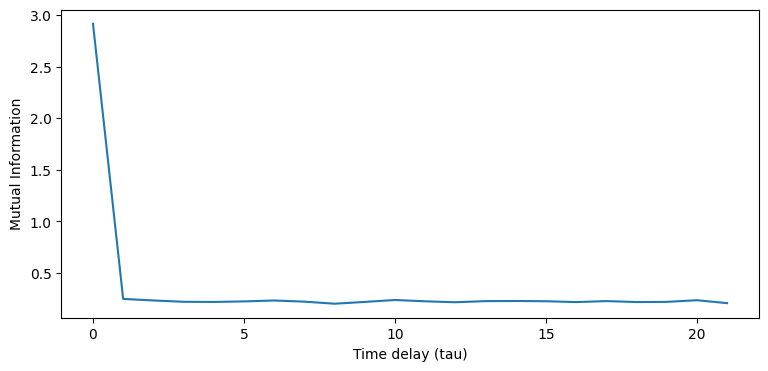

In [10]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y, maxtau=22))

In [11]:
def find_optimal_delay(x, maxtau=50): #Funcion que encuentra el delay optimo con nolitsa
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

find_optimal_delay(y, maxtau=22)

4

In [12]:
embedding_dimension_periodic = 10
embedding_time_delay_periodic = 4
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (3570, 10)


Se busca obtener la dimensión correcta

La dimensión óptima con tau=21 es:  6


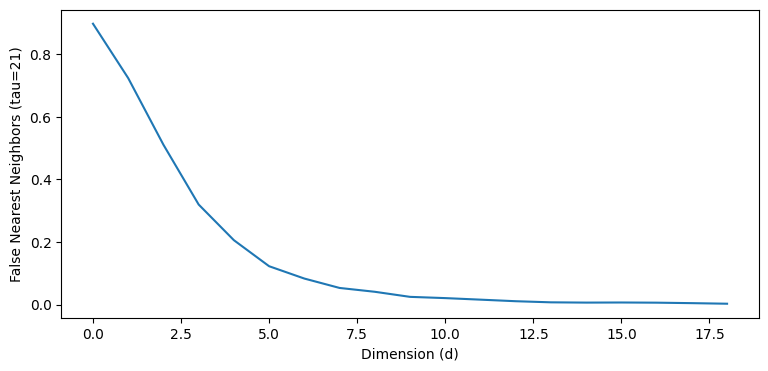

In [13]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(y, tau=21, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=21 es: ", [f<=0.1 for f in f1].index(True))

La dimensión óptima con tau=4 es:  6


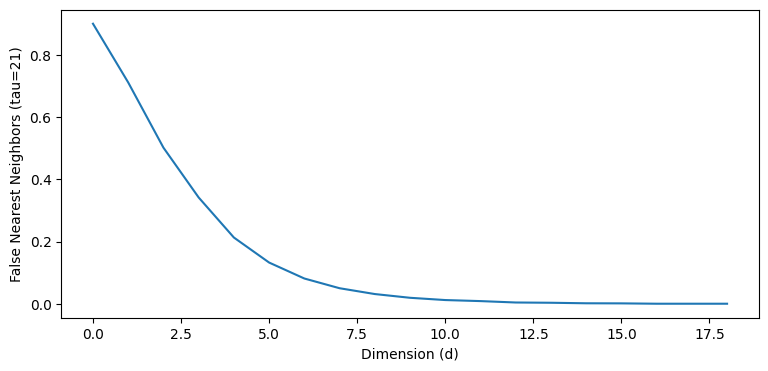

In [14]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(y, tau=4, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=4 es: ", [f<=0.1 for f in f1].index(True))

Habiendo usado diferentes tau llegamos a que la dimensión óptima es de 6.

In [15]:
embedding_dimension_periodic = 6
embedding_time_delay_periodic = 4
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (3586, 6)


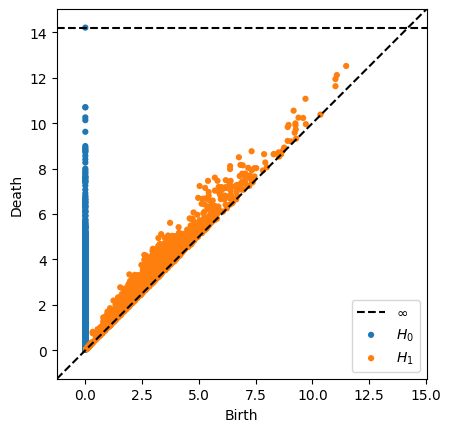

In [16]:
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

No se nota periodicidad, por lo que se realizará la generación de periodos para determinar si existe periodicidad en alguno de ellos.

## Periodos

In [17]:
# Extrae la variación de temperatura y el tiempo
consumo = todo['Consumption']
#temperatura2 = df.iloc[1:60,1:].values.flatten()
tiempo = todo['Tiempo']

# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo.shape[0])], 
    y=consumo, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Variación de consumo lo largo del día',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Medición de Consumo')
)

# Muestra la figura
fig.show()

Al observar esta gráfica podemos notar de mejor forma que en muchas mediciones el consumo es bajo. Se procederá ahora a realizar la generación de 6 periodos

In [18]:
consumo_periodo1 =  y[:902]
consumo_periodo2 =  y[902:1804]
consumo_periodo3 =  y[1804:2705]
consumo_periodo4 =  y[2705:3606]



#### Periodo 1

In [19]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo_periodo1.shape[0])], 
    y=consumo_periodo1, 
    mode='markers', 
    marker=dict(size=3),
    name='Consumo'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 1',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Consumo de Electricidadd')
)

# Muestra la figura
fig.show()

In [20]:
todo[:901]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
1218,20 Jan 2022,00:00:17,14.048,1900-01-01 00:00:17
932,16 Jan 2022,00:00:18,0.898,1900-01-01 00:00:18
1564,25 Feb 2022,00:00:41,1.096,1900-01-01 00:00:41
341,06 Jan 2022,00:00:47,2.102,1900-01-01 00:00:47
260,05 Jan 2022,00:00:54,3.562,1900-01-01 00:00:54
...,...,...,...,...
1087,17 Feb 2022,05:57:23,1.904,1900-01-01 05:57:23
1233,20 Feb 2022,05:58:00,0.916,1900-01-01 05:58:00
1198,19 Feb 2022,05:58:19,1.000,1900-01-01 05:58:19
339,06 Feb 2022,05:58:49,1.038,1900-01-01 05:58:49


Parece notarse periodicidad en este periodo. Este periodo va desde el primer registro a las 00:00:17 hasta las 5:59:13.

In [21]:
tauu= find_optimal_delay(consumo_periodo1)


La dimensión óptima con tau= 1  es:  7


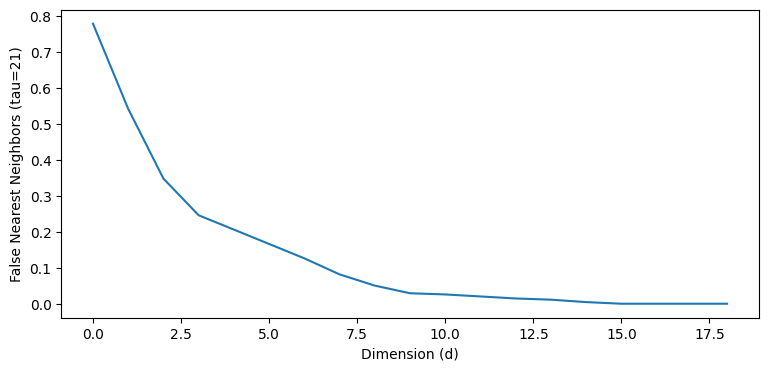

In [22]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo1, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

Para no tener que colocar siempre el código del encaje de takens se usará la siguiente función que genera el encaje

In [23]:
def encaje_takens(y,embedding_time_delay_periodic,embedding_dimension_periodic,stride=1):

    embedder_periodic = SingleTakensEmbedding(
        parameters_type="fixed",
        n_jobs=2,
        time_delay=embedding_time_delay_periodic,
        dimension=embedding_dimension_periodic,
        stride=stride,
    )

    y_periodic_embedded = embedder_periodic.fit_transform(y)
    return y_periodic_embedded

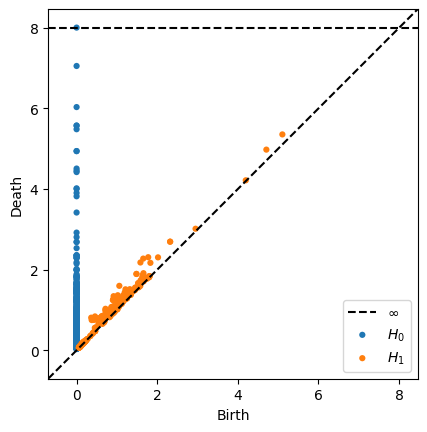

In [24]:
y_periodic_embedded = encaje_takens(consumo_periodo1,1,7,stride=1)

ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

usetex mode requires TeX.


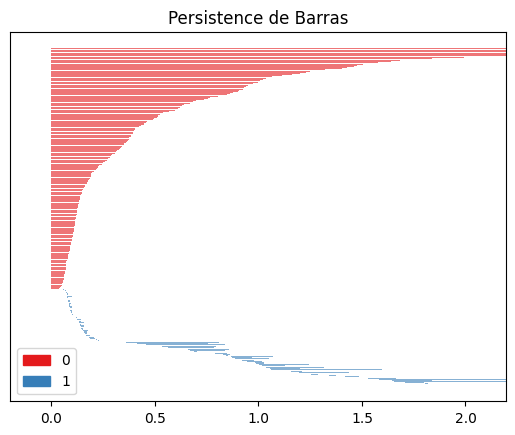

In [25]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf)
plt.title(f'Persistence de Barras')
plt.show()



Habiendo realizado la gráfica de persistencia podemos notar que en el primer periodo no hay periodicidad

#### Periodo 2

In [26]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo_periodo2.shape[0])], 
    y=consumo_periodo2, 
    mode='markers', 
    marker=dict(size=3),
    name='Consumo'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 2',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Consumo de Electricidadd')
)

# Muestra la figura
fig.show()

In [27]:
todo[902:1803]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
39,01 Feb 2022,06:00:26,0.884,1900-01-01 06:00:26
258,25 Jan 2022,06:00:34,0.980,1900-01-01 06:00:34
1518,24 Feb 2022,06:01:44,1.936,1900-01-01 06:01:44
1130,19 Jan 2022,06:02:24,3.702,1900-01-01 06:02:24
796,13 Jan 2022,06:03:33,0.988,1900-01-01 06:03:33
...,...,...,...,...
598,10 Feb 2022,11:53:23,4.006,1900-01-01 11:53:23
1270,20 Feb 2022,11:53:27,1.700,1900-01-01 11:53:27
546,09 Jan 2022,11:54:29,0.940,1900-01-01 11:54:29
360,27 Jan 2022,11:54:30,3.410,1900-01-01 11:54:30


Este periodo va de las 06:00:26 a las 11:55:29

La dimensión óptima con tau= 1  es:  5


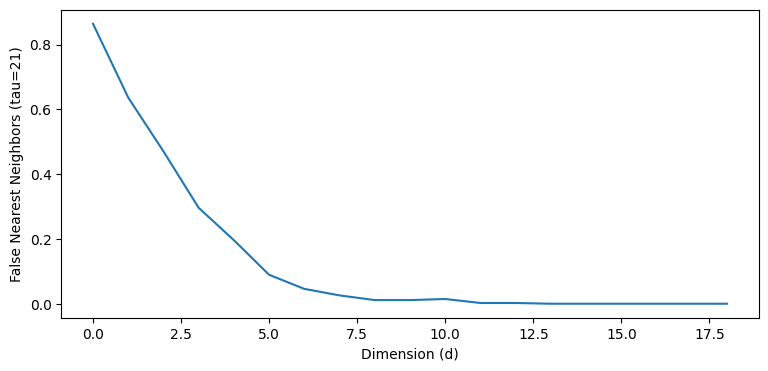

In [28]:
tauu= find_optimal_delay(consumo_periodo2)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo2, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

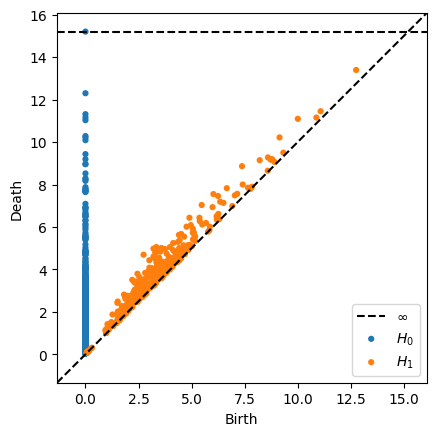

In [29]:
y_periodic_embedded = encaje_takens(consumo_periodo2,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

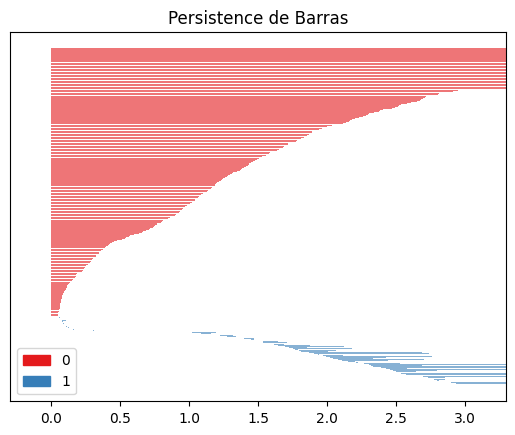

In [30]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf)
plt.title(f'Persistence de Barras')
plt.show()

No hay periodicidad.
### Periodo 3

In [31]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo_periodo3.shape[0])], 
    y=consumo_periodo3, 
    mode='markers', 
    marker=dict(size=3),
    name='Consumo'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 3',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Consumo de Electricidadd')
)

# Muestra la figura
fig.show()

In [32]:
todo[1804:2704]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
704,11 Feb 2022,11:55:53,3.316,1900-01-01 11:55:53
240,04 Feb 2022,11:56:06,1.000,1900-01-01 11:56:06
1666,27 Feb 2022,11:56:32,1.036,1900-01-01 11:56:32
1496,24 Feb 2022,11:56:49,0.876,1900-01-01 11:56:49
60,01 Feb 2022,11:57:31,1.024,1900-01-01 11:57:31
...,...,...,...,...
676,11 Feb 2022,17:48:28,3.688,1900-01-01 17:48:28
225,04 Feb 2022,17:48:56,0.938,1900-01-01 17:48:56
1201,20 Jan 2022,17:50:05,3.588,1900-01-01 17:50:05
11,21 Jan 2022,17:50:18,4.770,1900-01-01 17:50:18


Este periodo va desde las 11:55:53 a las 17:51:10

La dimensión óptima con tau= 1  es:  6


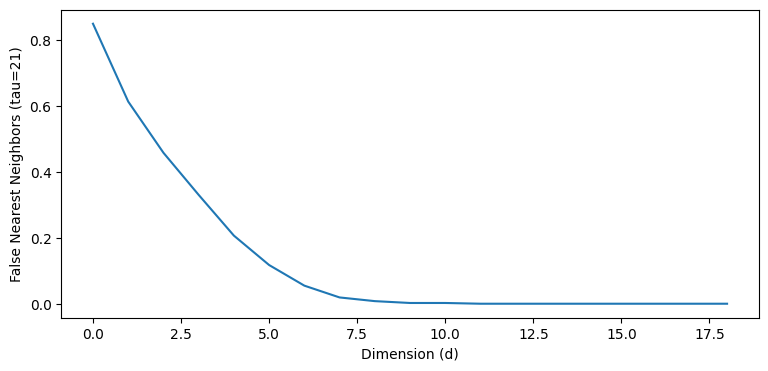

In [33]:
tauu= find_optimal_delay(consumo_periodo3)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo3, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

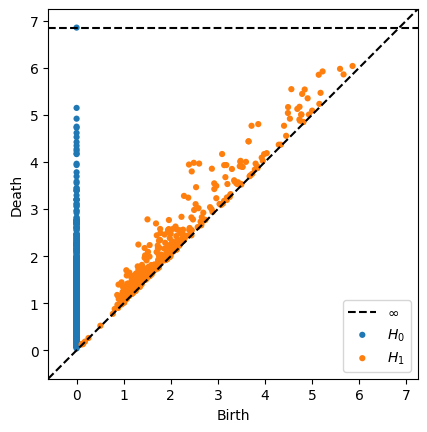

In [34]:
y_periodic_embedded = encaje_takens(consumo_periodo3,1,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

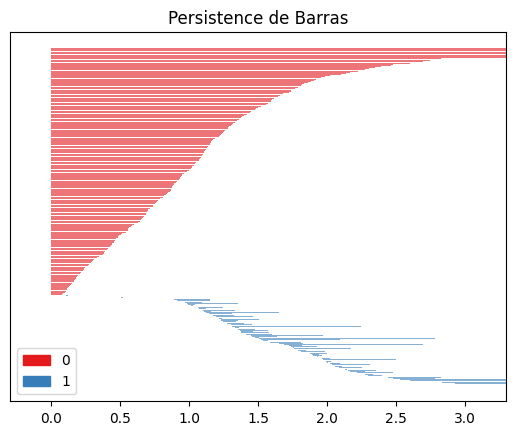

In [35]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf)
plt.title(f'Persistence de Barras')
plt.show()

No se nota periodicidad

### Periodo 4

In [36]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo_periodo4.shape[0])], 
    y=consumo_periodo4, 
    mode='markers', 
    marker=dict(size=3),
    name='Consumo'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 4',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Consumo de Electricidadd')
)

# Muestra la figura
fig.show()

In [37]:
todo[2705:]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
233,24 Jan 2022,17:52:26,6.126,1900-01-01 17:52:26
1475,24 Feb 2022,17:52:26,0.900,1900-01-01 17:52:26
492,29 Jan 2022,17:52:27,0.944,1900-01-01 17:52:27
1400,22 Feb 2022,17:54:27,0.932,1900-01-01 17:54:27
134,03 Jan 2022,17:54:34,5.028,1900-01-01 17:54:34
...,...,...,...,...
858,14 Jan 2022,23:58:52,0.948,1900-01-01 23:58:52
474,08 Feb 2022,23:58:57,0.926,1900-01-01 23:58:57
63,01 Feb 2022,23:59:16,0.884,1900-01-01 23:59:16
235,04 Feb 2022,23:59:48,0.928,1900-01-01 23:59:48


Este periodo va desde 17:52:26 hasta las 23:59:55

La dimensión óptima con tau= 2  es:  4


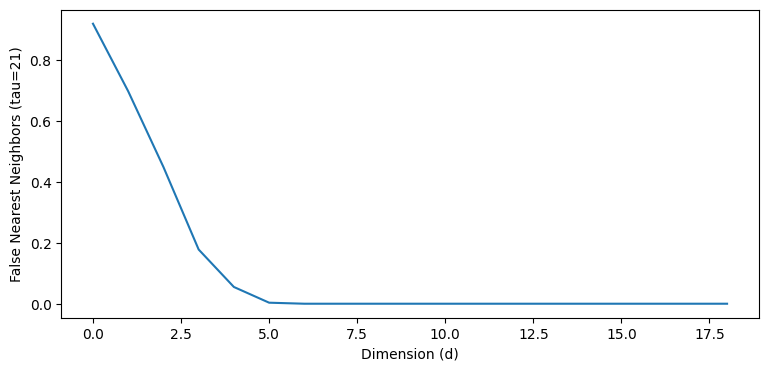

In [38]:
tauu= find_optimal_delay(consumo_periodo4)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo4, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

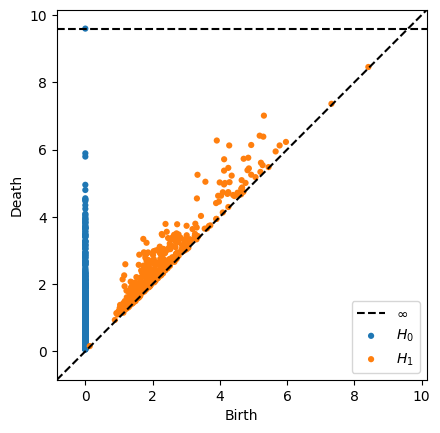

In [39]:
y_periodic_embedded = encaje_takens(consumo_periodo4,2,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

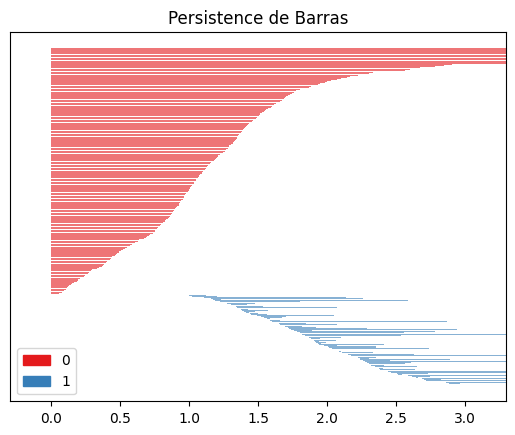

In [40]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf)
plt.title(f'Persistence de Barras')
plt.show()

El periodo 4 es el que parece estar más cerca de ser cíclico

### Primeros resultados
Notamos que con los 4 periodos que se hicieron no hay evidencia de que estos sean cíclicos. Así que se realizaran nuevos periodos.

In [41]:
consumo_periodo1 =  y[:602]
consumo_periodo2 =  y[602:1203]
consumo_periodo3 =  y[1203:1804]
consumo_periodo4 =  y[1804:2405]
consumo_periodo5 =  y[2405:3006]
consumo_periodo6 =  y[3006:3606]


### Periodo 1

In [42]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(consumo_periodo1.shape[0])], 
    y=consumo_periodo1, 
    mode='markers', 
    marker=dict(size=3),
    name='Consumo'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 1',
    xaxis=dict(title='Registro'),
    yaxis=dict(title='Consumo de Electricidadd')
)

# Muestra la figura
fig.show()

Este periodo va desde las 00:00:17 a las 03:58:52

La dimensión óptima con tau= 1  es:  7


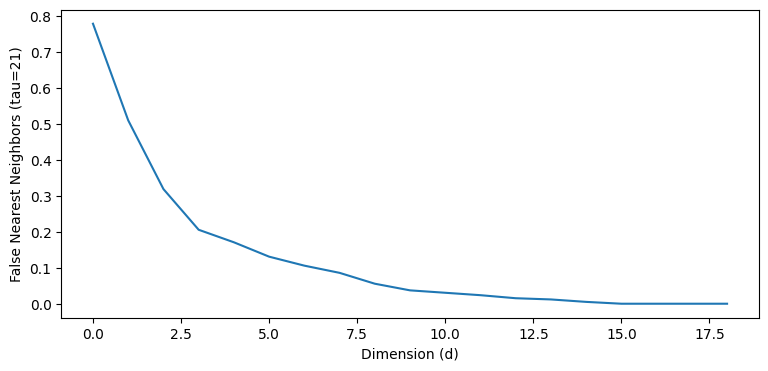

In [43]:
tauu= find_optimal_delay(consumo_periodo1)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo1, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=21)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

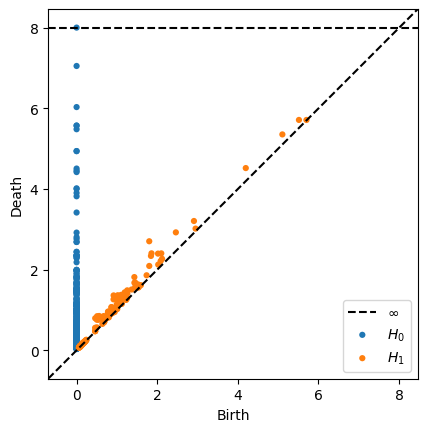

In [44]:
y_periodic_embedded = encaje_takens(consumo_periodo1,1,7,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

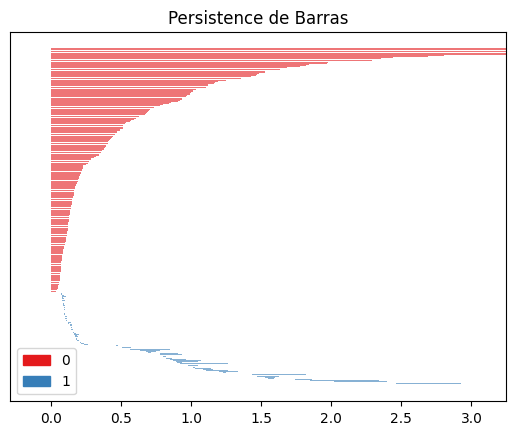

In [45]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf1 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf1)
plt.title(f'Persistence de Barras')
plt.show()

### Periodo 2

In [46]:
todo[602:1202]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
1691,28 Feb 2022,04:00:39,1.816,1900-01-01 04:00:39
138,03 Jan 2022,04:00:43,1.324,1900-01-01 04:00:43
439,07 Feb 2022,04:01:00,1.040,1900-01-01 04:01:00
53,01 Feb 2022,04:01:08,0.908,1900-01-01 04:01:08
780,13 Feb 2022,04:01:12,1.130,1900-01-01 04:01:12
...,...,...,...,...
1692,28 Feb 2022,07:53:38,0.976,1900-01-01 07:53:38
920,15 Jan 2022,07:53:49,0.932,1900-01-01 07:53:49
313,06 Jan 2022,07:54:03,9.110,1900-01-01 07:54:03
308,05 Feb 2022,07:54:33,0.932,1900-01-01 07:54:33


Este periodo va desde las 4:00:39 a las 7:55:27

La dimensión óptima con tau= 3  es:  7


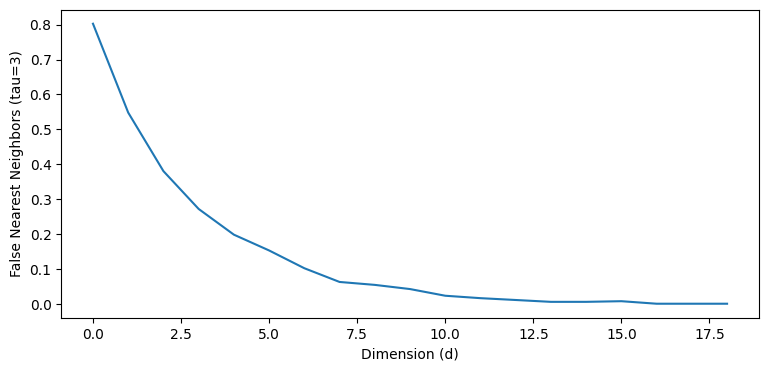

In [47]:
tauu= find_optimal_delay(consumo_periodo2)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo2, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=3)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

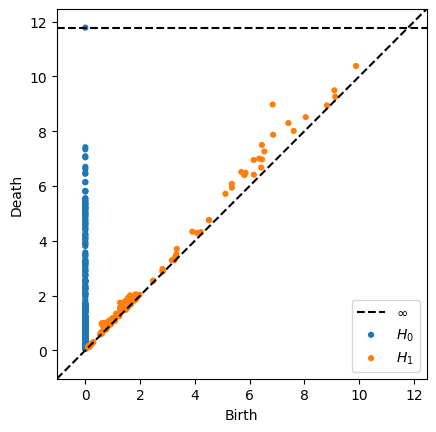

In [48]:
y_periodic_embedded = encaje_takens(consumo_periodo2,3,7,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

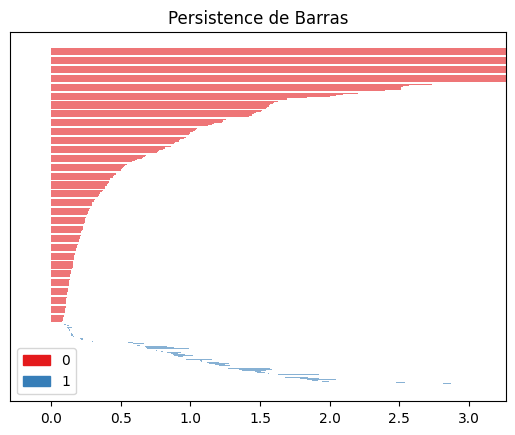

In [49]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf2 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf2)
plt.title(f'Persistence de Barras')
plt.show()

### Periodo 3

In [50]:
todo[1203:1803]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
1402,22 Feb 2022,07:55:49,8.748,1900-01-01 07:55:49
1626,26 Feb 2022,07:56:23,0.872,1900-01-01 07:56:23
655,11 Jan 2022,07:56:26,0.908,1900-01-01 07:56:26
749,12 Feb 2022,07:56:58,1.036,1900-01-01 07:56:58
462,08 Feb 2022,07:57:00,0.936,1900-01-01 07:57:00
...,...,...,...,...
598,10 Feb 2022,11:53:23,4.006,1900-01-01 11:53:23
1270,20 Feb 2022,11:53:27,1.700,1900-01-01 11:53:27
546,09 Jan 2022,11:54:29,0.940,1900-01-01 11:54:29
360,27 Jan 2022,11:54:30,3.410,1900-01-01 11:54:30


Este periodo va de las 7:55:49 a las 11:55:29

La dimensión óptima con tau= 1  es:  5


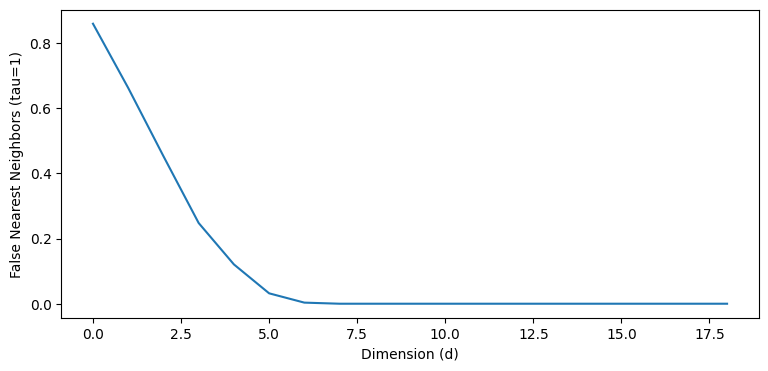

In [51]:
tauu= find_optimal_delay(consumo_periodo3)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo3, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

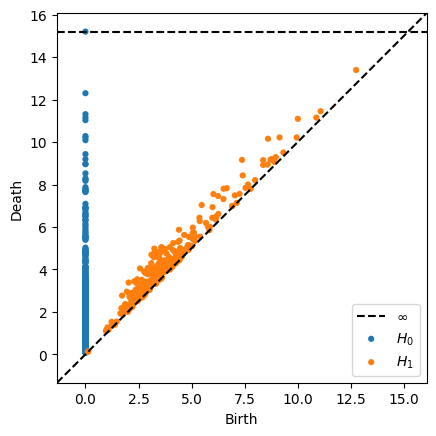

In [52]:
y_periodic_embedded = encaje_takens(consumo_periodo3,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

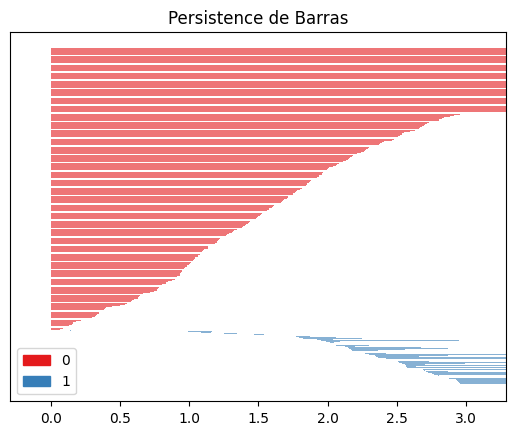

In [53]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf3 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf3)
plt.title(f'Persistence de Barras')
plt.show()

### Periodo 4

In [54]:
todo[1804:2404]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
704,11 Feb 2022,11:55:53,3.316,1900-01-01 11:55:53
240,04 Feb 2022,11:56:06,1.000,1900-01-01 11:56:06
1666,27 Feb 2022,11:56:32,1.036,1900-01-01 11:56:32
1496,24 Feb 2022,11:56:49,0.876,1900-01-01 11:56:49
60,01 Feb 2022,11:57:31,1.024,1900-01-01 11:57:31
...,...,...,...,...
158,03 Jan 2022,15:48:01,2.556,1900-01-01 15:48:01
729,12 Feb 2022,15:48:14,1.036,1900-01-01 15:48:14
1081,18 Jan 2022,15:48:17,3.500,1900-01-01 15:48:17
1689,28 Feb 2022,15:49:23,1.024,1900-01-01 15:49:23


Este periodo va de las 11:55:53 a las 15:49:35

La dimensión óptima con tau= 1  es:  6


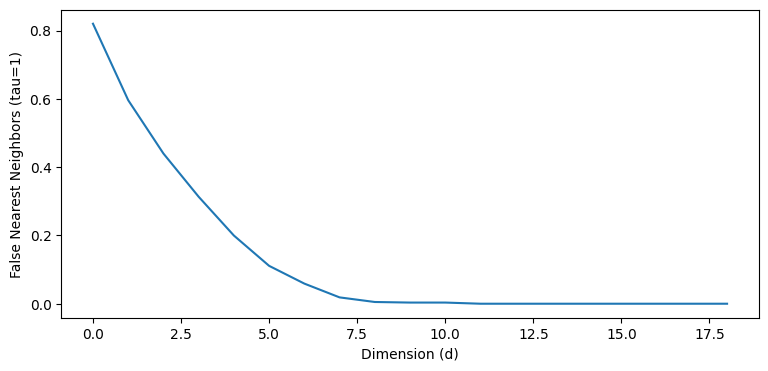

In [55]:
tauu= find_optimal_delay(consumo_periodo4)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo4, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

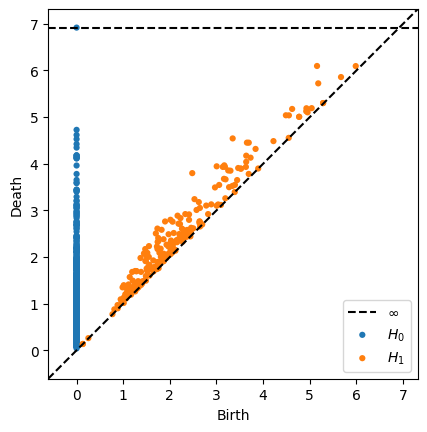

In [56]:
y_periodic_embedded = encaje_takens(consumo_periodo4,1,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

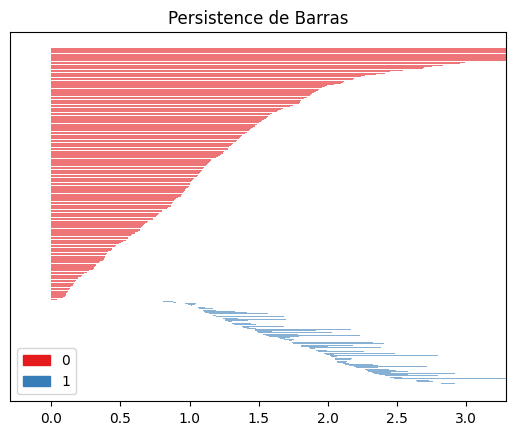

In [57]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf4 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf4)
plt.title(f'Persistence de Barras')
plt.show()

### Periodo 5

In [58]:
todo[2405:3005]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
1304,21 Feb 2022,15:49:50,0.936,1900-01-01 15:49:50
579,10 Jan 2022,15:50:47,0.904,1900-01-01 15:50:47
110,02 Feb 2022,15:51:48,2.022,1900-01-01 15:51:48
256,25 Jan 2022,15:51:52,5.614,1900-01-01 15:51:52
786,13 Feb 2022,15:52:00,1.020,1900-01-01 15:52:00
...,...,...,...,...
366,07 Jan 2022,19:58:56,8.204,1900-01-01 19:58:56
125,03 Jan 2022,19:59:23,5.622,1900-01-01 19:59:23
1703,28 Feb 2022,19:59:33,0.984,1900-01-01 19:59:33
209,24 Jan 2022,20:00:18,8.008,1900-01-01 20:00:18


Este periodo va desde las 15:49:50 a las 20:00:57

La dimensión óptima con tau= 1  es:  5


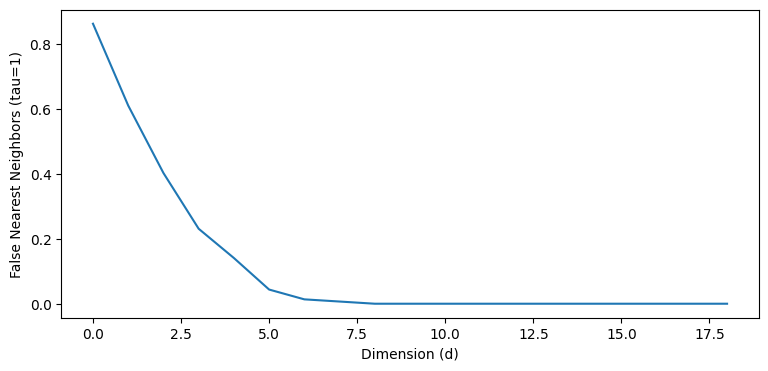

In [59]:
tauu= find_optimal_delay(consumo_periodo5)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo5, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

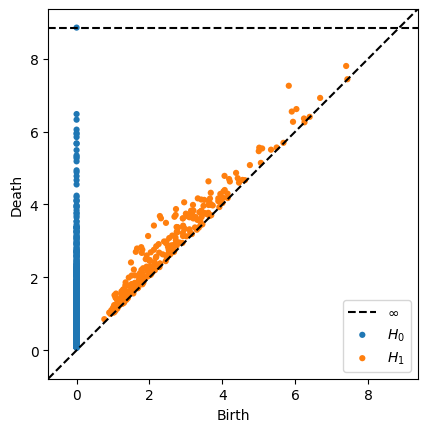

In [60]:
y_periodic_embedded = encaje_takens(consumo_periodo5,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

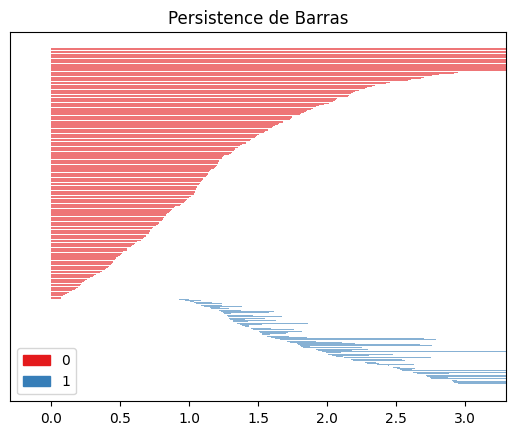

In [61]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 3)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf5 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf5)
plt.title(f'Persistence de Barras')
plt.show()

### Periodo 6

In [62]:
todo[3006:3606]

,Fecha,Tiempo,Consumption,TiempoconOtroFormato
690,11 Feb 2022,20:02:16,11.244,1900-01-01 20:02:16
772,13 Jan 2022,20:02:46,8.784,1900-01-01 20:02:46
323,06 Jan 2022,20:03:00,8.976,1900-01-01 20:03:00
426,28 Jan 2022,20:03:14,4.952,1900-01-01 20:03:14
619,10 Feb 2022,20:03:45,5.376,1900-01-01 20:03:45
...,...,...,...,...
858,14 Jan 2022,23:58:52,0.948,1900-01-01 23:58:52
474,08 Feb 2022,23:58:57,0.926,1900-01-01 23:58:57
63,01 Feb 2022,23:59:16,0.884,1900-01-01 23:59:16
235,04 Feb 2022,23:59:48,0.928,1900-01-01 23:59:48


Este periodo va de las 20:03:00 a las 23:59:55

La dimensión óptima con tau= 2  es:  4


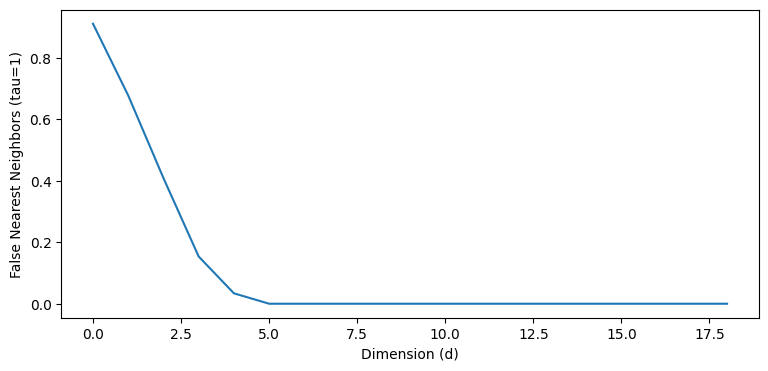

In [63]:
tauu= find_optimal_delay(consumo_periodo6)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo6, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

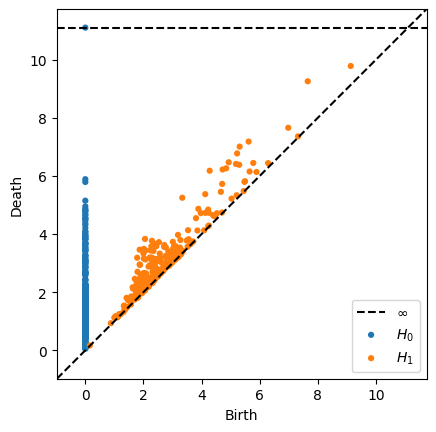

In [64]:
y_periodic_embedded = encaje_takens(consumo_periodo6,2,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

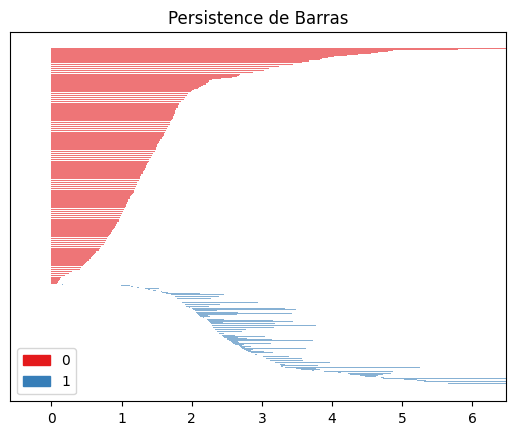

In [65]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf6 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf6)
plt.title(f'Persistence de Barras')
plt.show()

Hasta ahora no han habido indicios de que los datos sean cíclicos, se realizará una nueva periodización de los datos para determinar si son cíclicos, serán 12 periodos en total que abarcarán alrededor 2 horas en el día.

Los periodos tendrían que ser de 300.5, pero como no se puede se realizará una aproximación y no todos los periodos tendrán la misma cantidad de registros

### 12 Periodos

In [66]:
consumo_periodo1 =  y[:301]
consumo_periodo2 =  y[301:601]
consumo_periodo3 =  y[601:902]
consumo_periodo4 =  y[902:1202]
consumo_periodo5 =  y[1202:1503]
consumo_periodo6 =  y[1503:1803]
consumo_periodo7 =  y[1803:2104]
consumo_periodo8 =  y[2104:2404]
consumo_periodo9 =  y[2404:2705]
consumo_periodo10 =  y[2705:3005]
consumo_periodo11 =  y[3006:3306]
consumo_periodo12 =  y[3306:3607]


### Periodo 1

La dimensión óptima con tau= 1  es:  6


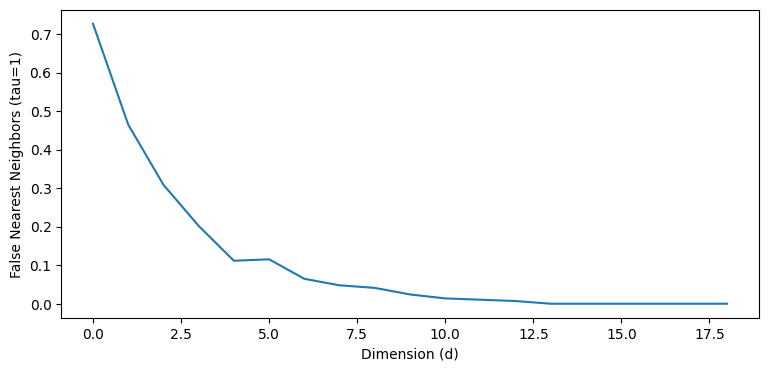

In [67]:
tauu= find_optimal_delay(consumo_periodo1)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo1, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

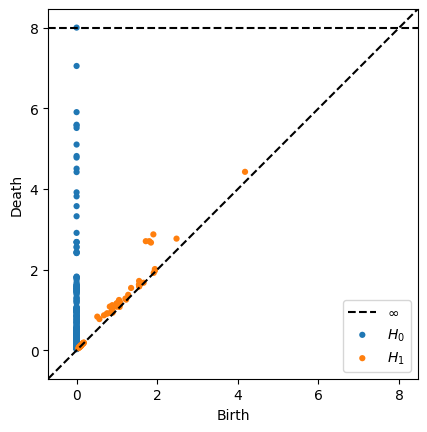

In [68]:
y_periodic_embedded = encaje_takens(consumo_periodo1,1,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)

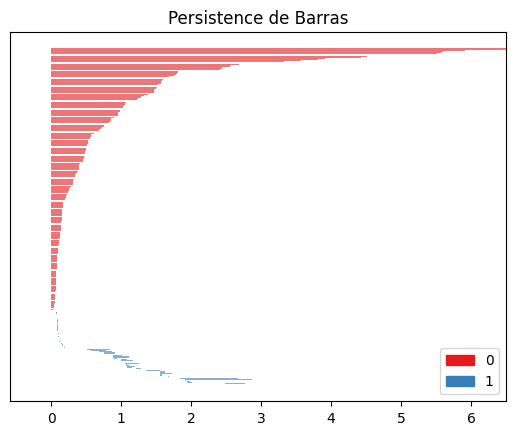

In [69]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf1 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf1)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 2

La dimensión óptima con tau= 3  es:  6


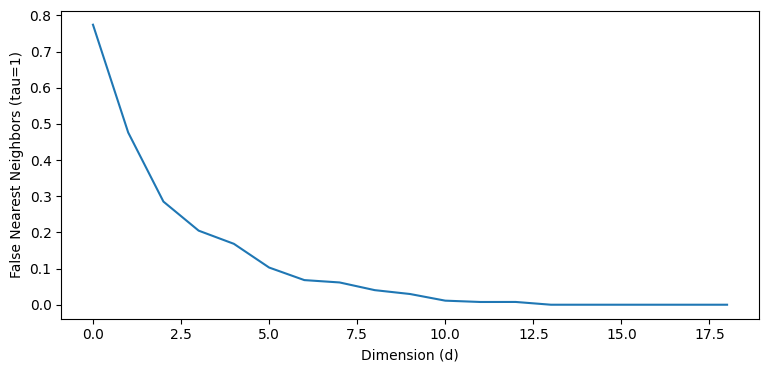

In [70]:
tauu= find_optimal_delay(consumo_periodo2)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo2, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

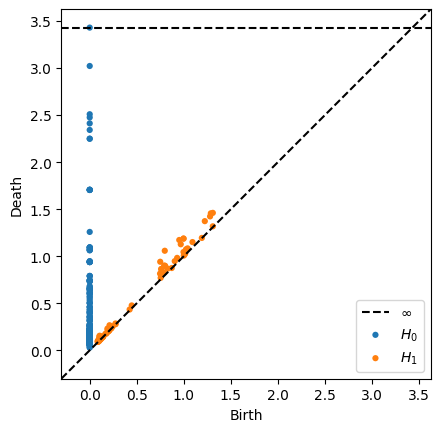

In [71]:
y_periodic_embedded = encaje_takens(consumo_periodo2,3,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True
)

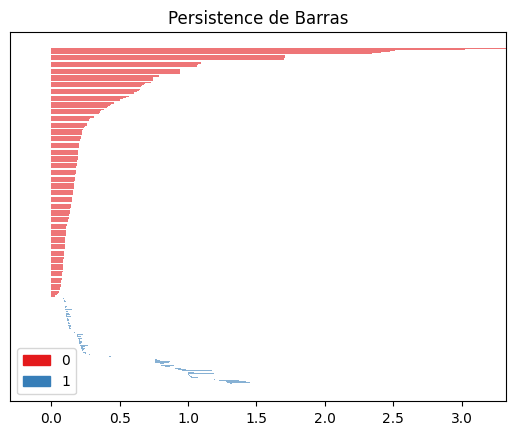

In [72]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf2 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf2)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 3

La dimensión óptima con tau= 1  es:  6


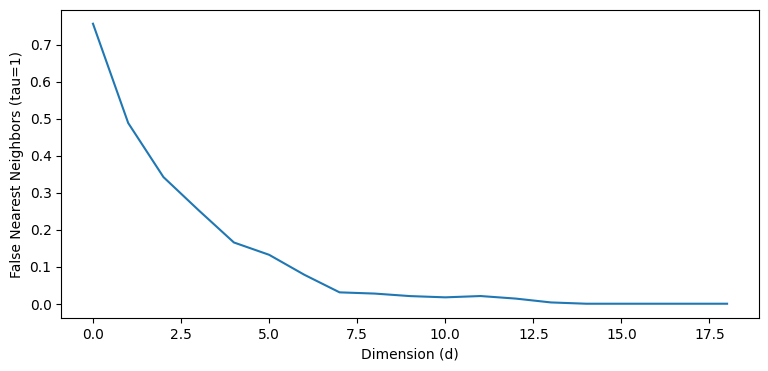

In [73]:
tauu= find_optimal_delay(consumo_periodo3)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo3, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))

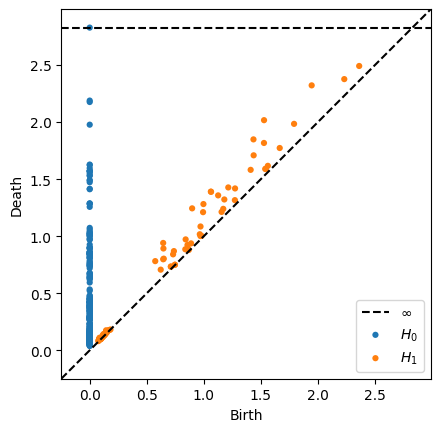

In [74]:
y_periodic_embedded = encaje_takens(consumo_periodo3,1,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)

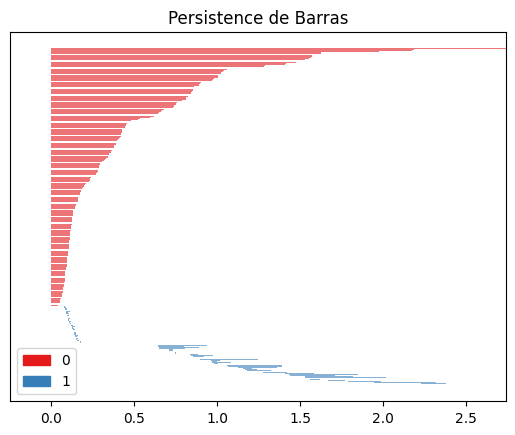

In [75]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf3 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf3)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 4

La dimensión óptima con tau= 3  es:  6


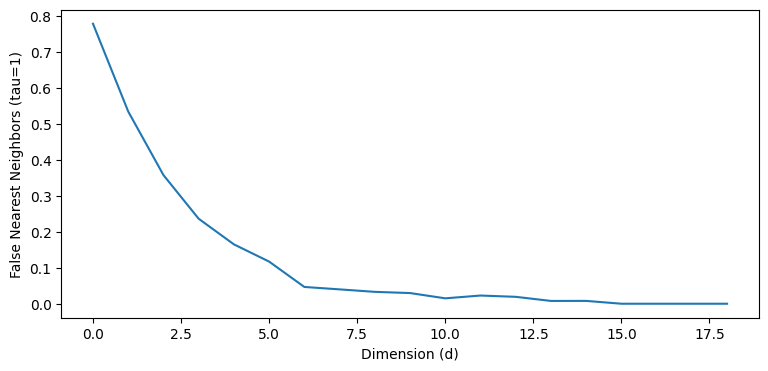

In [76]:
tauu= find_optimal_delay(consumo_periodo4)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo4, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


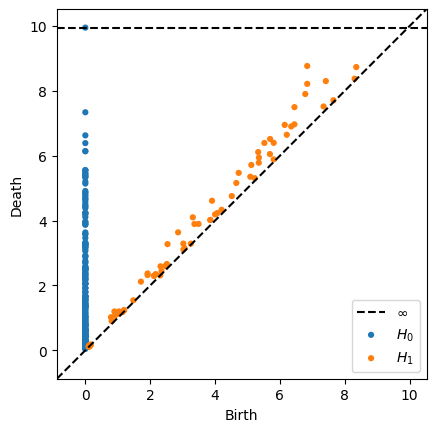

In [77]:
y_periodic_embedded = encaje_takens(consumo_periodo4,3,6,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


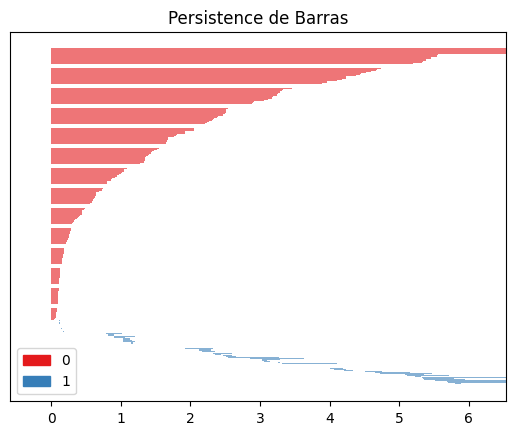

In [78]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf4 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf4)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 5


La dimensión óptima con tau= 1  es:  4


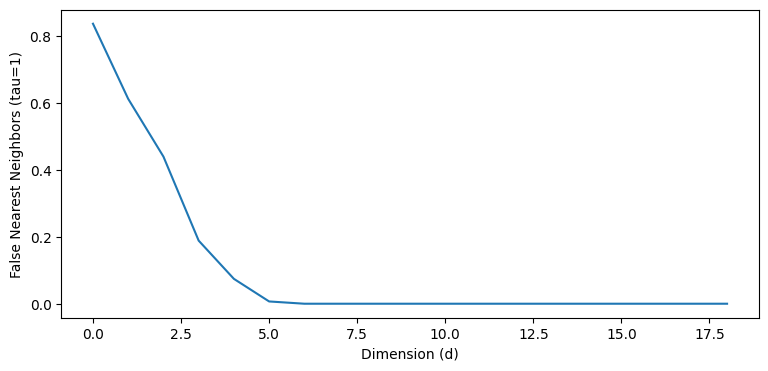

In [79]:
tauu= find_optimal_delay(consumo_periodo5)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo5, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


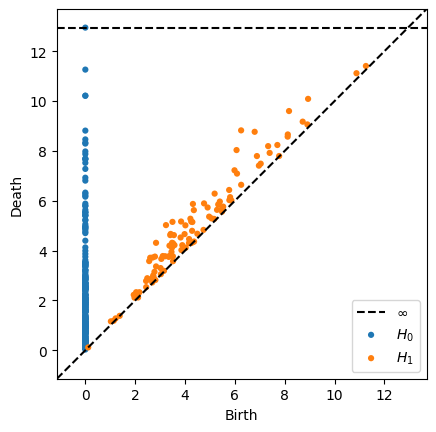

In [80]:
y_periodic_embedded = encaje_takens(consumo_periodo5,1,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)

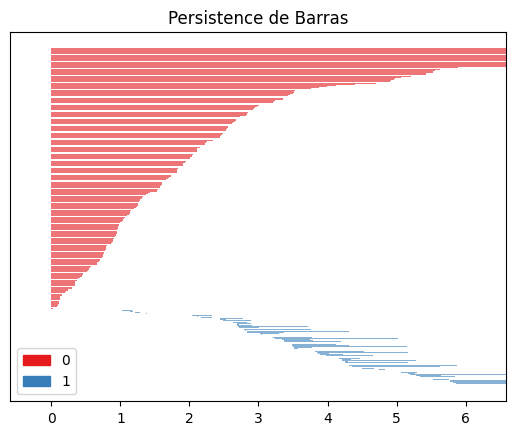

In [81]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf5 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf5)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 6

La dimensión óptima con tau= 3  es:  4


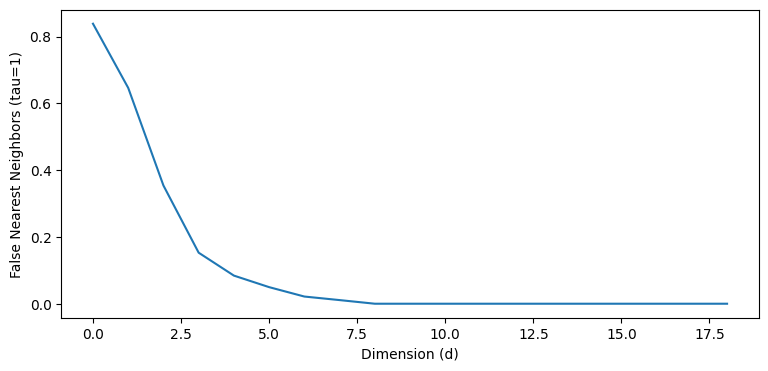

In [82]:
tauu= find_optimal_delay(consumo_periodo6)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo6, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


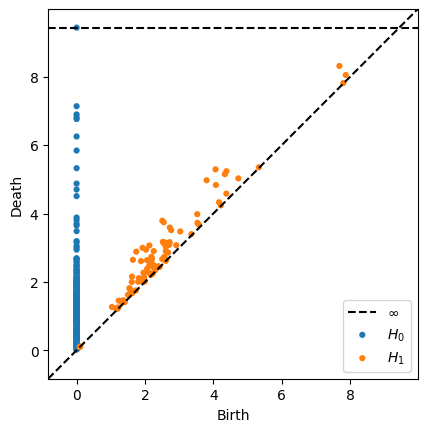

In [83]:
y_periodic_embedded = encaje_takens(consumo_periodo6,3,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)



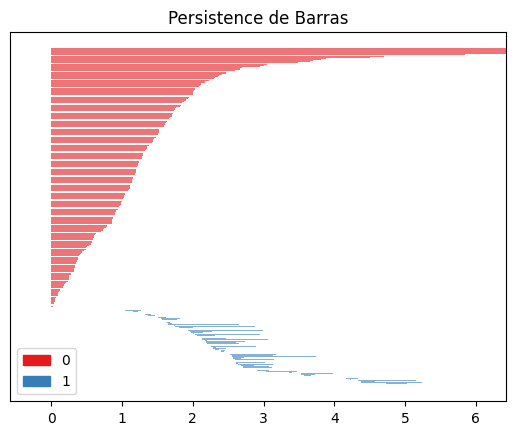

In [84]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf6 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf6)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 7

La dimensión óptima con tau= 1  es:  5


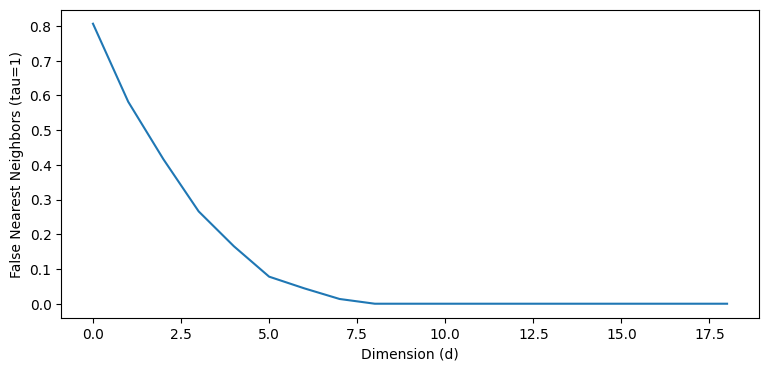

In [85]:
tauu= find_optimal_delay(consumo_periodo7)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo7, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


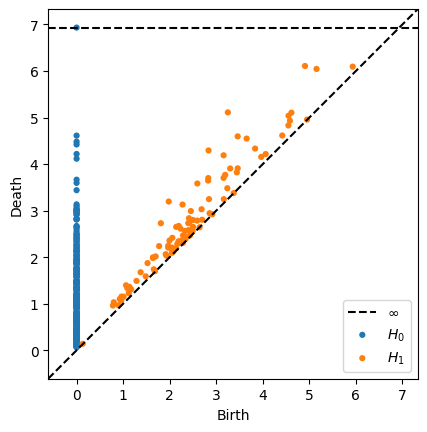

In [86]:
y_periodic_embedded = encaje_takens(consumo_periodo7,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


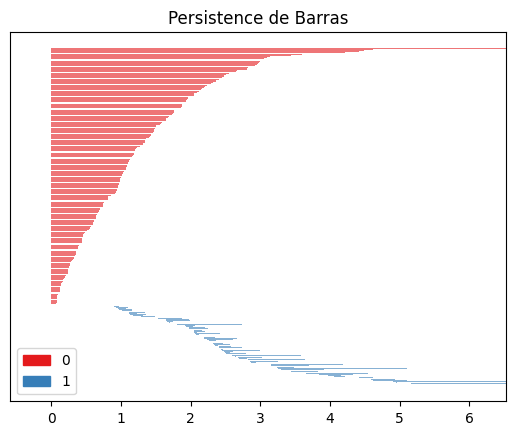

In [87]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf7 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf7)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 8


La dimensión óptima con tau= 1  es:  5


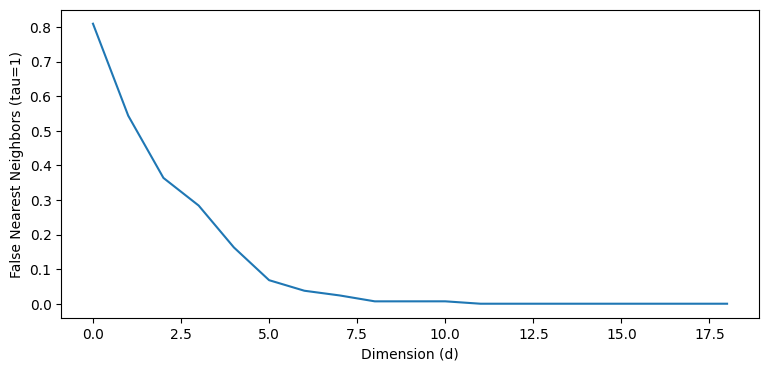

In [88]:
tauu= find_optimal_delay(consumo_periodo8)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo8, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


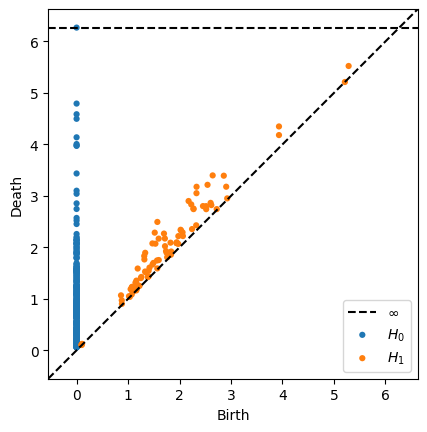

In [89]:
y_periodic_embedded = encaje_takens(consumo_periodo8,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


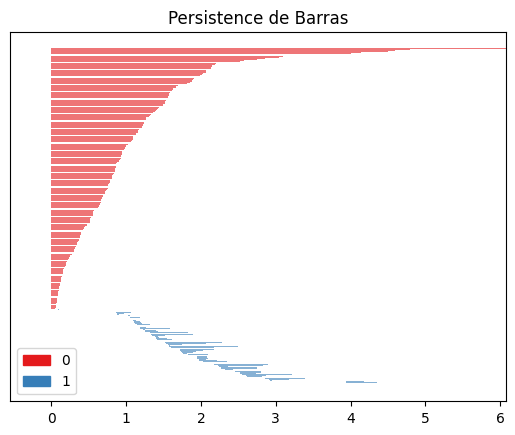

In [90]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf8 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf8)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 9

La dimensión óptima con tau= 1  es:  5


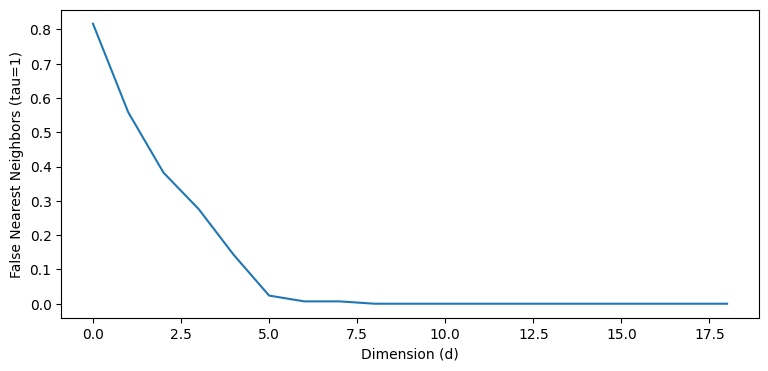

In [91]:
tauu= find_optimal_delay(consumo_periodo9)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo9, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


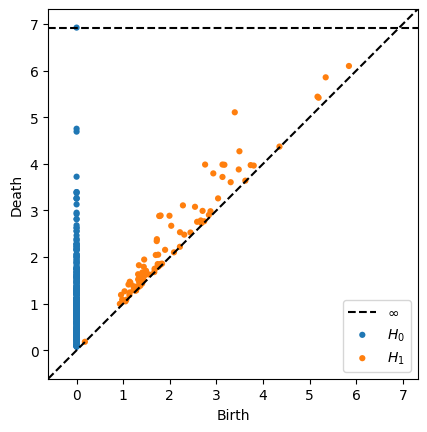

In [92]:
y_periodic_embedded = encaje_takens(consumo_periodo9,1,5,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


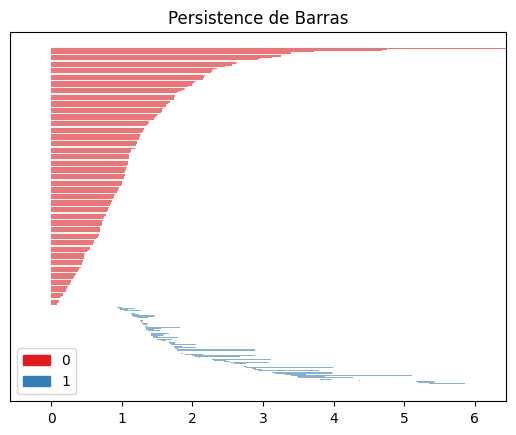

In [93]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf9 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf9)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 10

La dimensión óptima con tau= 3  es:  4


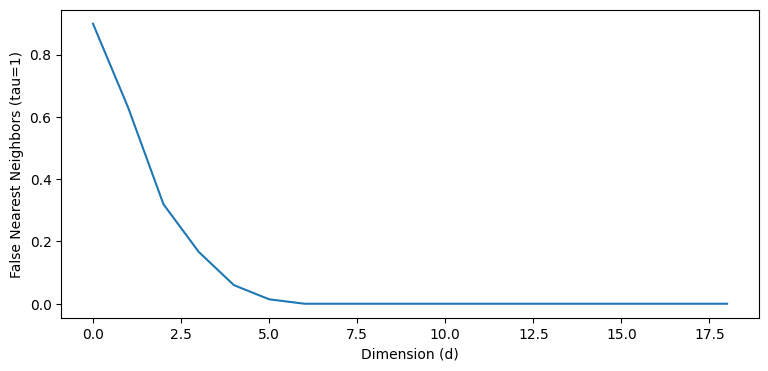

In [94]:

tauu= find_optimal_delay(consumo_periodo10)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo10, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))



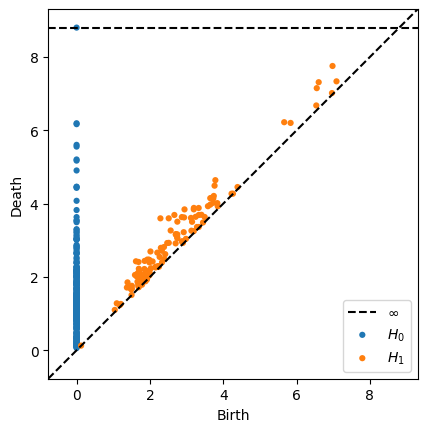

In [95]:
y_periodic_embedded = encaje_takens(consumo_periodo10,3,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


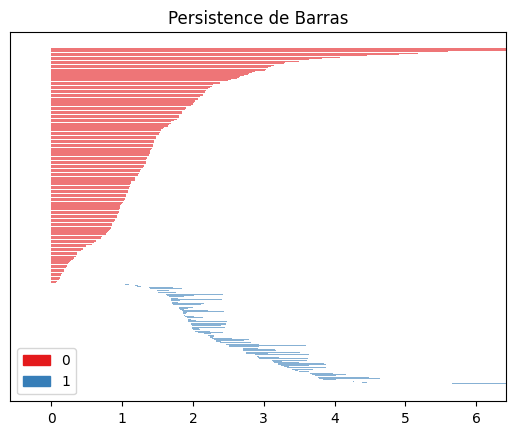

In [96]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf10 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf10)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 11

La dimensión óptima con tau= 2  es:  4


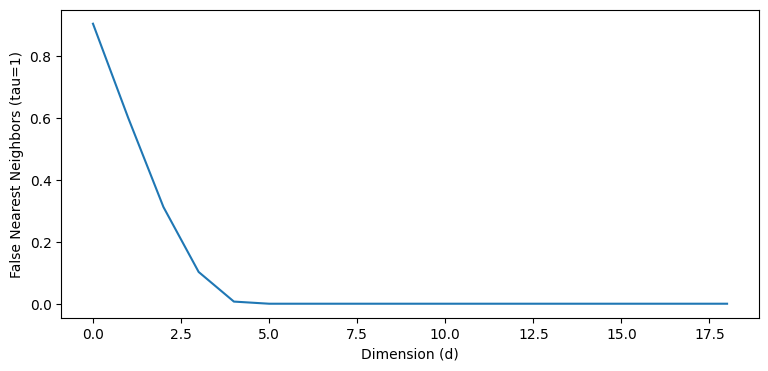

In [97]:
tauu= find_optimal_delay(consumo_periodo11)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo11, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


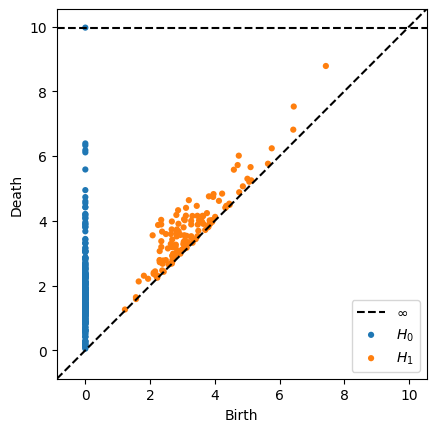

In [98]:
y_periodic_embedded = encaje_takens(consumo_periodo11,2,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)

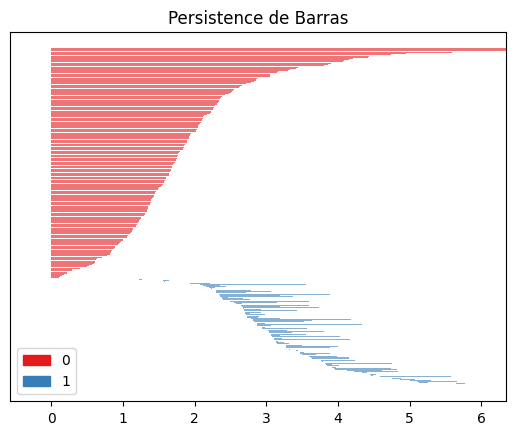

In [99]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf11 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf11)
plt.title(f'Persistence de Barras')
plt.show()

#### Periodo 12

La dimensión óptima con tau= 3  es:  4


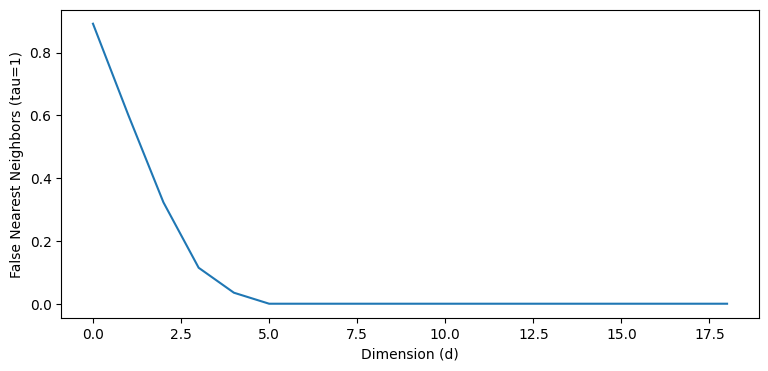

In [100]:
tauu= find_optimal_delay(consumo_periodo12)
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(consumo_periodo12, tau=tauu, dim=dim, maxnum=100)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=1)')
plt.plot(f1)
print("La dimensión óptima con tau=", tauu," es: ", [f<=0.1 for f in f1].index(True))


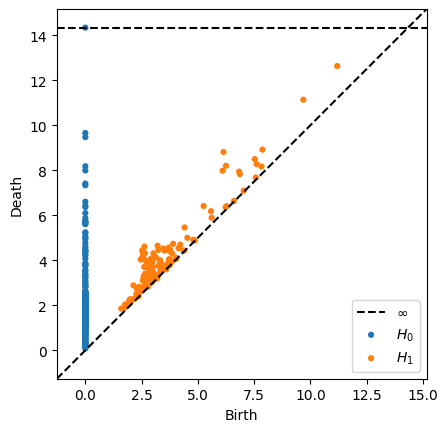

In [101]:
y_periodic_embedded = encaje_takens(consumo_periodo12,3,4,stride=1)
ripserperiod=ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(
    ripserperiod,
    show=True)


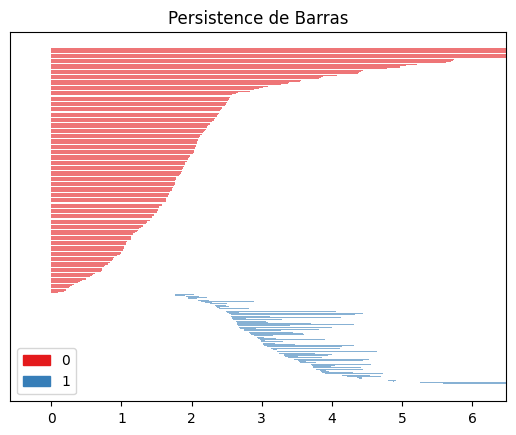

In [102]:
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded, max_edge_length = 6)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
diag_inf12 = Rips_simplex_tree_Circ.persistence(min_persistence=0)
gd.plot_persistence_barcode(diag_inf12)
plt.title(f'Persistence de Barras')
plt.show()

El periodo 11 y 12 presentan periodicidad. Se va a comparar que tan parecidos son los dem'as periodos con estos dos. Solo que se compararan entre los que tengan la misma dimension, puesto que al ser 3606 datos al crear 12 periodos se tuvieron que crear algunos de distinto tamaño.

In [103]:
len(consumo_periodo1)#301
len(consumo_periodo2)#300
len(consumo_periodo3)#301
len(consumo_periodo4)#300
len(consumo_periodo5)#301
len(consumo_periodo6)#300
len(consumo_periodo7)#301
len(consumo_periodo8)#300
len(consumo_periodo9)#301
len(consumo_periodo10)#300
len(consumo_periodo11)#300
len(consumo_periodo12)#300

300